In [8]:
# Install needed packages
! pip install opencv-python
! pip install tensorflow
! pip install mtcnn

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import collections
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Load Pretrained Model

Tested models:

* EfficientNetB0
* MobileNetV2
* Resnet50

In [14]:
# Load Pretrained Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

# Add task-specific layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Replace 4 with the number of your classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Step 2: Prepare Your Dataset

In [15]:
# Set the base directory
base_dir = os.getcwd()  # Get the current working directory

# Construct the path to the dataset
dataset_dir = os.path.join(base_dir, 'dataset')

# Construct the path to the training directory
train_dir = os.path.join(dataset_dir, 'train')

# Construct the path to the validation directory
val_dir = os.path.join(dataset_dir, 'val')

# Data augmentation for training
data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# No augmentation for validation, just rescaling
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare generators
print("Train data")
train_generator = data_augmentation.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

print("Validation data")
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Train data
Found 3919 images belonging to 4 classes.
Validation data
Found 395 images belonging to 4 classes.


### Step 3: Train the Model

Early stopping is a technique that stops training when a monitored metric (like validation loss) stops improving, 
helping avoid overfitting and reducing unnecessary computations.

A checkpoint saves model weights (and other information) at certain points (often the best performance), 
ensuring you can restore or deploy those weights without retraining from scratch.

In [16]:
modelFileName = 'bestmodel.keras'

# Train the model with early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(modelFileName, save_best_only=True, monitor="val_loss", verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

callbacks = [early_stopping, checkpoint_callback, reduce_lr]

# Train the new layers initially using train_generator and val_generator
print("Training the new layers")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

# Fine-tune the entire model
base_model.trainable = True  # Unfreeze the base layers

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the entire model
print("Fine-tuning the entire model")
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Save the trained model
model.save(modelFileName)


Training the new layers


c:\Users\mika\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.4642 - loss: 1.2900
Epoch 1: val_loss improved from inf to 0.55517, saving model to bestmodel.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 105s 800ms/step - accuracy: 0.4650 - loss: 1.2879 - val_accuracy: 0.7924 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6905 - loss: 0.7664
Epoch 2: val_loss did not improve from 0.55517
123/123 ━━━━━━━━━━━━━━━━━━━━ 88s 711ms/step - accuracy: 0.6907 - loss: 0.7662 - val_accuracy: 0.7873 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7639 - loss: 0.6483
Epoch 3: val_loss improved from 0.55517 to 0.49887, saving model to bestmodel.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 86s 698ms/step - accuracy: 0.7639 - loss: 0.6483 - val_accuracy: 0.8329 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7710 - loss: 0.6016
Epoc

### Analyze learning

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


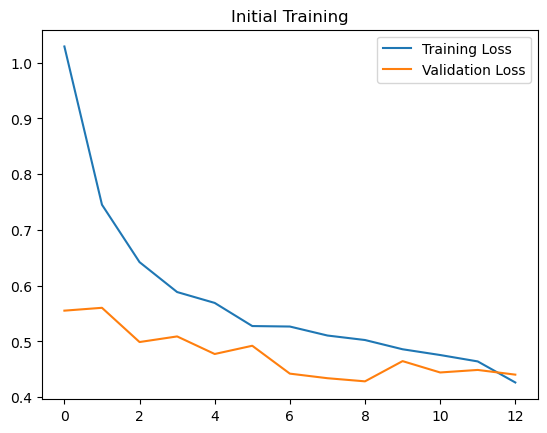

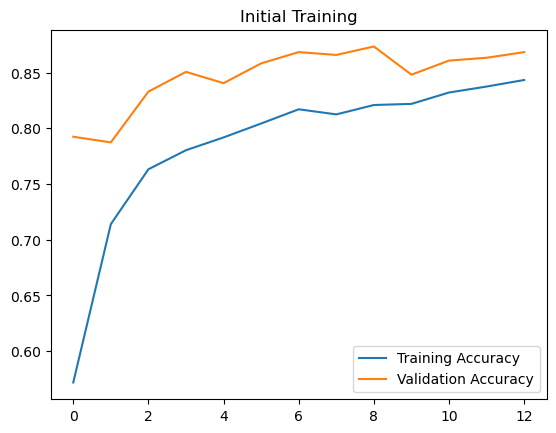

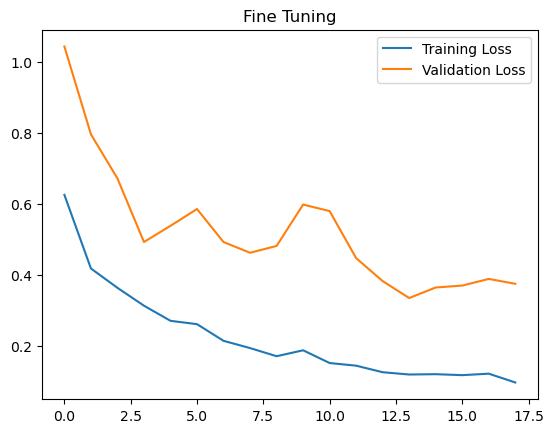

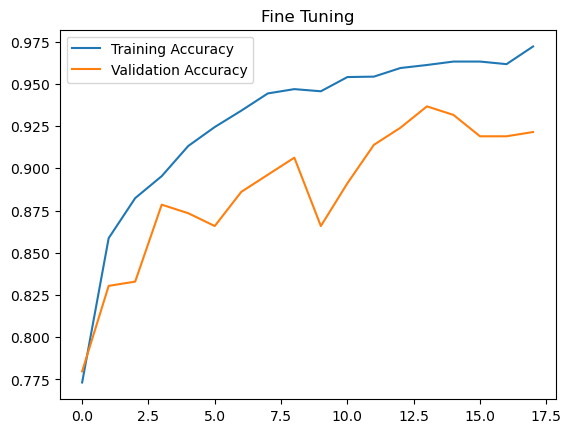

In [17]:
print(history.history.keys())
print(history_fine.history.keys())

# Plot loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training')
plt.legend()
plt.show()

# Repeat for accuracy if recorded
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training')
plt.legend()
plt.show()

# Plot loss and validation loss
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Fine Tuning')
plt.legend()
plt.show()

# Repeat for accuracy if recorded
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine Tuning')
plt.legend()
plt.show()


Found 379 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.9061 - loss: 0.3788
Test Loss: 0.3698388934135437
Test Accuracy: 0.9102902412414551
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step


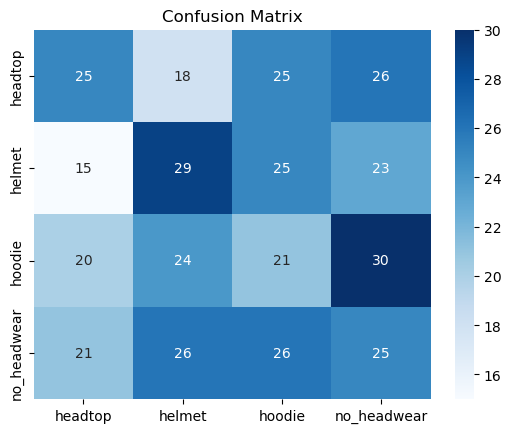

              precision    recall  f1-score   support

     headtop       0.31      0.27      0.29        94
      helmet       0.30      0.32      0.31        92
      hoodie       0.22      0.22      0.22        95
 no_headwear       0.24      0.26      0.25        98

    accuracy                           0.26       379
   macro avg       0.27      0.26      0.26       379
weighted avg       0.27      0.26      0.26       379



In [18]:
# Construct the path to the test directory
test_dir = os.path.join(dataset_dir, 'test')

# Data augmentation for test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

predictions = model.predict(test_generator)  # Get predicted probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Class indices of predictions
true_classes = test_generator.classes  # Ground-truth labels
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


### Step 4: Real-Time Webcam Prediction

This needs to be run outside Jupyter notebook environment for real time webcam access and output. Test script is in webcam-predirector.py file.
Run in python shell: 

``
python webcam-predictor.py
``